In [1]:
%matplotlib widget 

import numpy as np
import matplotlib.pyplot as plt

# import the local dev version
import sys
sys.path.insert(0,'/Users/james/Dropbox/research_projects/pykosmos')

import pykosmos as pk
print(pk.__version__)

0.3.8


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':12})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
arcfile = '../kosmos-testing/UT211008/int_neon_c3.0001.fits'
img = pk.proc(arcfile, bias=None, trim=False, Waxis=0)
img.shape

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(4096, 2148)

In [4]:
# img.header

In [5]:
trace = np.ones(img.shape[0]) + 1000

# bkgd_sub=False: important to NOT subtract the background (sky) from the arc
ext = pk.BoxcarExtract(img.data, #- np.median(img.data), # since we not removing a bias, could help a little to subtract off baseline
                       trace,  Waxis=0, skysep=3, skywidth=1, bkgd_sub=False)

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_45325/222969471.py:4: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  ext = pk.BoxcarExtract(img.data, #- np.median(img.data), # since we not removing a bias, could help a little to subtract off baseline


In [6]:
# the available templates within pykosmos currently
pk.loadarctemplate(help=True)

['/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/DIS_B400.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrRed0.86-high.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/DIS_R300.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrRed1.18-ctr.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrBlue1.18-ctr.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrBlue0.86-high.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/ArRed2.0-low.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/NeBlue2.0-low.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/ArRed1.18-ctr.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplate

In [7]:
# since we're only doing a Neon lamp, just load 1, but note you *can* load multiple and combine them
# BUT, combine templates from multiple grism settings with caution...
ref = pk.loadarctemplate('NeRed1.18-ctr.spec')
print(len(ref.flux.value))

4096


Text(0, 0.5, 'arbitrary flux')

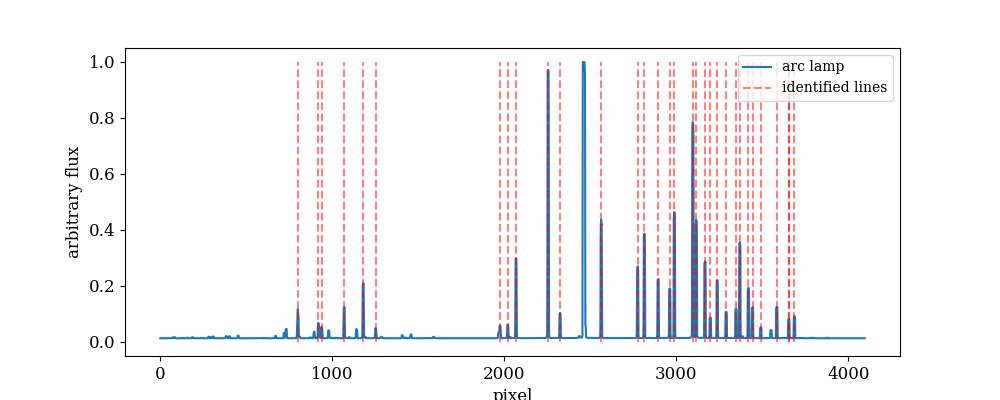

In [11]:
# the "Dynamic Time Warping" automatic alignment
xpts, wpts = pk.identify_dtw(ext, ref, pthreshold=1)

plt.figure(figsize=(10,4))
plt.plot(ext.flux/np.max(ext.flux.value), label='arc lamp')
# plt.plot(ref.flux/np.max(ref.flux.value))
plt.vlines(xpts, 0,1, color='r', linestyle='--', alpha=0.5, label='identified lines')
plt.legend(fontsize=10)
plt.xlabel('pixel')
plt.ylabel('arbitrary flux')

Text(0, 0.5, 'arbitrary flux')

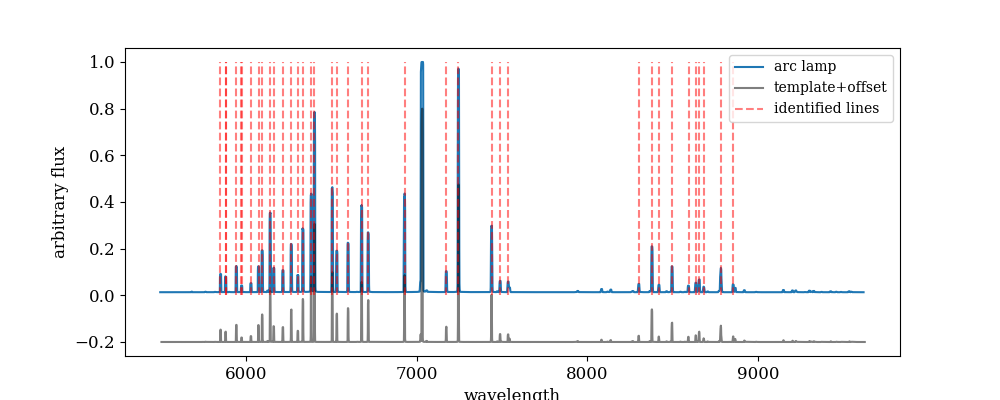

In [9]:
# now fit the wavelength solution for these (xpts,wpts) with a spline, and apply the wavelength solution to the arc
arc_fit = pk.fit_wavelength(ext, xpts, wpts, mode='spline')
# if it complains ValueError: Spectral axis must be strictly increasing or decreasing.
# then try a simplier model (e.g. mode='poly', with deg=1)

plt.figure(figsize=(10,4))
plt.plot(arc_fit.spectral_axis, arc_fit.flux/np.max(arc_fit.flux.value), label='arc lamp')
plt.plot(ref.spectral_axis, ref.flux.value/np.max(ref.flux.value) - 0.2, label='template+offset',alpha=0.5, c='k')
plt.vlines(wpts, 0,1, color='r', linestyle='--', alpha=0.5, label='identified lines')
plt.legend(fontsize=10)
plt.xlabel('wavelength')
plt.ylabel('arbitrary flux')